In [830]:
import warnings
warnings.filterwarnings("ignore")

In [831]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from simpledbf import Dbf5

from factor_analyzer.factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
import sklearn.linear_model as lm
from sklearn.feature_selection import r_regression

import requests
import csv
import json

In [832]:
## Just a test!
## Limitations:
### Just Nov 2024 data (no 2020, 2022, March 2024 election results)
### Probably other limitations as well

In [833]:
dbf = Dbf5("shapes/ca_24_allraces.dbf")
data = dbf.to_dataframe()
data.head()

,SRPREC,COUNTY,FIPS_CODE,SRPREC_KEY,G24PDem,G24PRep,G24POth,G24PTot,G24SDem,G24SRep,...,G24PR3_T,G24PR4_N,G24PR4_Y,G24PR4_Y_2,G24PR5_N,G24PR5_Y,G24PR5_T,G24PR6_N,G24PR6_Y,G24PR6_T
0,491650,001,06001,06001491650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,205200,001,06001,06001205200,3432,114,112,3658,3317,190,...,3561,478,3049,3527,1139,2319,3458,721,2700,3421
2,547720,001,06001,06001547720,1980,974,191,3145,1910,1079,...,3064,1349,1699,3048,2085,935,3020,1783,1157,2940
3,833300,001,06001,06001833300,1483,847,99,2429,1442,883,...,2323,846,1476,2322,1258,1041,2299,1172,1069,2241
4,333410,001,06001,06001333410,1792,317,108,2217,1800,309,...,2161,444,1704,2148,704,1427,2131,688,1407,2095


In [834]:
# data = pd.read_csv("data/state_g24_sov_data_by_g24_svprec.csv")
# data.head()

In [835]:
data.shape

(24202, 53)

In [836]:
full_data = data.copy()
full_data.shape

(24202, 53)

In [837]:
data['SRPREC'].map(lambda x: x[:3])

0        491
1        205
2        547
3        833
4        333
        ... 
24197    518
24198    520
24199    522
24200    522
24201    524
Name: SRPREC, Length: 24202, dtype: object

In [838]:
# data = data[(data['SVPREC'].map(lambda x: x[-3:]) != 'TOT') &
#     (data['SVPREC'].map(lambda x: x[:3] != 'SOV'))]

In [839]:
data.columns.values

array(['SRPREC', 'COUNTY', 'FIPS_CODE', 'SRPREC_KEY', 'G24PDem',
       'G24PRep', 'G24POth', 'G24PTot', 'G24SDem', 'G24SRep', 'G24STot',
       'G24SSDem', 'G24SSRep', 'G24SSTot', 'G24HDem', 'G24HRep',
       'G24HTot', 'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem',
       'G24SLDLRep', 'G24SLDLTot', 'G24PR2_N', 'G24PR2_Y', 'G24PR2_T',
       'G24PR32_N', 'G24PR32_Y', 'G24PR32_T', 'G24PR33_N', 'G24PR33_Y',
       'G24PR33_T', 'G24PR34_N', 'G24PR34_Y', 'G24PR34_T', 'G24PR35_N',
       'G24PR35_Y', 'G24PR35_T', 'G24PR36_N', 'G24PR36_Y', 'G24PR36_T',
       'G24PR3_N', 'G24PR3_Y', 'G24PR3_T', 'G24PR4_N', 'G24PR4_Y',
       'G24PR4_Y_2', 'G24PR5_N', 'G24PR5_Y', 'G24PR5_T', 'G24PR6_N',
       'G24PR6_Y', 'G24PR6_T'], dtype=object)

In [840]:
data.shape

(24202, 53)

In [841]:
data = data.rename({
    'SRPREC_KEY': 'SVPREC_KEY',
    'G24PDem': 'PRSDEM01',
    'G24PRep': 'PRSREP01',
    'G24POth': 'PRSOTH01',
    'G24PTot': 'pres_tot',
    'G24SDem': 'SENDEM01',
    'G24SRep': 'SENREP01',
    'G24STot': 'sen_tot'
}, axis=1)

for i in [2, 3, 4, 5, 6, 32, 33, 34, 35, 36]:
    data = data.rename({
        f'G24PR{i}_N': f'PR_{i}_N',
        f'G24PR{i}_Y': f'PR_{i}_Y'
    }, axis=1)

data.columns.values

array(['SRPREC', 'COUNTY', 'FIPS_CODE', 'SVPREC_KEY', 'PRSDEM01',
       'PRSREP01', 'PRSOTH01', 'pres_tot', 'SENDEM01', 'SENREP01',
       'sen_tot', 'G24SSDem', 'G24SSRep', 'G24SSTot', 'G24HDem',
       'G24HRep', 'G24HTot', 'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot',
       'G24SLDLDem', 'G24SLDLRep', 'G24SLDLTot', 'PR_2_N', 'PR_2_Y',
       'G24PR2_T', 'PR_32_N', 'PR_32_Y', 'G24PR32_T', 'PR_33_N',
       'PR_33_Y', 'G24PR33_T', 'PR_34_N', 'PR_34_Y', 'G24PR34_T',
       'PR_35_N', 'PR_35_Y', 'G24PR35_T', 'PR_36_N', 'PR_36_Y',
       'G24PR36_T', 'PR_3_N', 'PR_3_Y', 'G24PR3_T', 'PR_4_N', 'PR_4_Y',
       'G24PR4_Y_2', 'PR_5_N', 'PR_5_Y', 'G24PR5_T', 'PR_6_N', 'PR_6_Y',
       'G24PR6_T'], dtype=object)

In [842]:
# data = data[~data[['PR_2_N', 'PR_2_Y', 'PR_32_N',
#        'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
#        'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
#        'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y']].isna()]

In [843]:
cols = [
    'SVPREC_KEY', 'PR_2_N', 'PR_2_Y', 'PR_32_N',
       'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
       'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
       'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y', 'PRSDEM01',
       'PRSOTH01', 'PRSREP01', 'pres_tot', 'SENDEM01', 'SENREP01', 'sen_tot'
]

data = data[cols]
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,PR_5_Y,PR_6_N,PR_6_Y,PRSDEM01,PRSOTH01,PRSREP01,pres_tot,SENDEM01,SENREP01,sen_tot
0,06001491650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,06001205200,591,2912,775,2691,2091,1274,2225,1022,842,...,2319,721,2700,3432,112,114,3658,3317,190,3507
2,06001547720,1546,1502,1486,1534,2088,914,1319,1577,1078,...,935,1783,1157,1980,191,974,3145,1910,1079,2989
3,06001833300,882,1439,949,1362,1254,1015,949,1312,639,...,1041,1172,1069,1483,99,847,2429,1442,883,2325
4,06001333410,522,1623,621,1516,978,1117,1118,897,431,...,1427,688,1407,1792,108,317,2217,1800,309,2109


In [844]:
prop_cols = ['PR_2', 'PR_32', 'PR_33', 'PR_34', 'PR_35', 'PR_4', 'PR_36', 'PR_3', 'PR_5', 'PR_6']

for prop in prop_cols:
    data[f'{prop}_Y'] = data[f'{prop}_Y'].replace({'***':0}).astype(int)
    data[f'{prop}_N'] = data[f'{prop}_N'].replace({'***':0}).astype(int)
    data[f'{prop}_Y'] = data[f'{prop}_Y'] / (data[f'{prop}_Y'] + data[f'{prop}_N'])
    data = data.drop([f'{prop}_N'], axis='columns')

data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,PRSDEM01,PRSOTH01,PRSREP01,pres_tot,SENDEM01,SENREP01,sen_tot
0,06001491650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,06001205200,0.831287,0.776399,0.378603,0.314752,0.752789,0.375440,0.947767,0.864474,0.670619,0.789243,3432,112,114,3658,3317,190,3507
2,06001547720,0.492782,0.507947,0.304464,0.544544,0.639706,0.805995,0.617493,0.557415,0.309603,0.393537,1980,191,974,3145,1910,1079,2989
3,06001833300,0.619991,0.589355,0.447334,0.580274,0.722053,0.777440,0.617736,0.635659,0.452806,0.477019,1483,99,847,2429,1442,883,2325
4,06001333410,0.756643,0.709406,0.533174,0.445161,0.793780,0.536449,0.849144,0.793296,0.669639,0.671599,1792,108,317,2217,1800,309,2109


In [845]:
pres_cols = ['PRSDEM01', 'PRSREP01', 'PRSOTH01']

for cand in pres_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['pres_tot']

data = data.drop(['pres_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,PRSDEM01,PRSOTH01,PRSREP01,SENDEM01,SENREP01,sen_tot
0,06001491650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,06001205200,0.831287,0.776399,0.378603,0.314752,0.752789,0.375440,0.947767,0.864474,0.670619,0.789243,0.938218,0.030618,0.031165,3317,190,3507
2,06001547720,0.492782,0.507947,0.304464,0.544544,0.639706,0.805995,0.617493,0.557415,0.309603,0.393537,0.629571,0.060731,0.309698,1910,1079,2989
3,06001833300,0.619991,0.589355,0.447334,0.580274,0.722053,0.777440,0.617736,0.635659,0.452806,0.477019,0.610539,0.040758,0.348703,1442,883,2325
4,06001333410,0.756643,0.709406,0.533174,0.445161,0.793780,0.536449,0.849144,0.793296,0.669639,0.671599,0.808300,0.048714,0.142986,1800,309,2109


In [846]:
sen_cols = ['SENDEM01', 'SENREP01']

for cand in sen_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['sen_tot']

data = data.drop(['sen_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,PRSDEM01,PRSOTH01,PRSREP01,SENDEM01,SENREP01
0,06001491650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06001205200,0.831287,0.776399,0.378603,0.314752,0.752789,0.375440,0.947767,0.864474,0.670619,0.789243,0.938218,0.030618,0.031165,0.945823,0.054177
2,06001547720,0.492782,0.507947,0.304464,0.544544,0.639706,0.805995,0.617493,0.557415,0.309603,0.393537,0.629571,0.060731,0.309698,0.639010,0.360990
3,06001833300,0.619991,0.589355,0.447334,0.580274,0.722053,0.777440,0.617736,0.635659,0.452806,0.477019,0.610539,0.040758,0.348703,0.620215,0.379785
4,06001333410,0.756643,0.709406,0.533174,0.445161,0.793780,0.536449,0.849144,0.793296,0.669639,0.671599,0.808300,0.048714,0.142986,0.853485,0.146515


In [847]:
data = data.set_index(['SVPREC_KEY'])
data.head(1)

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,PRSDEM01,PRSOTH01,PRSREP01,SENDEM01,SENREP01
SVPREC_KEY,,,,,,,,,,,,,,,
06001491650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [848]:
data = data[(~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna())]
data.shape

(18054, 15)

In [849]:
# Default to oblimax
rot = 'promax'
n_factors = 2
df = data.drop(['PRSDEM01', 'PRSREP01', 'PRSOTH01', 'SENDEM01', 'SENREP01', 'PR_34_Y'], axis=1)

fa = FactorAnalyzer(rotation=rot, n_factors=n_factors)
fa.fit(df)
ev, v = fa.get_eigenvalues()
ev

array([7.13255829, 0.74283917, 0.38426862, 0.2291528 , 0.14712055,
       0.12330591, 0.10997428, 0.07132108, 0.0594593 ])

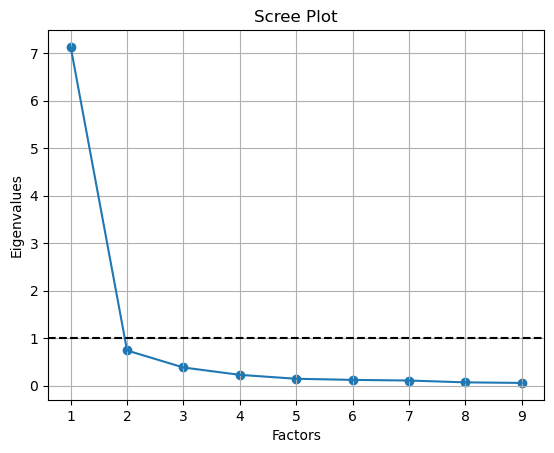

In [850]:
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, linestyle='--', color='black')
plt.grid()
plt.show()

In [851]:
alpha = cronbach_alpha(data=df)
alpha

(0.9085468314529422, array([0.907, 0.911]))

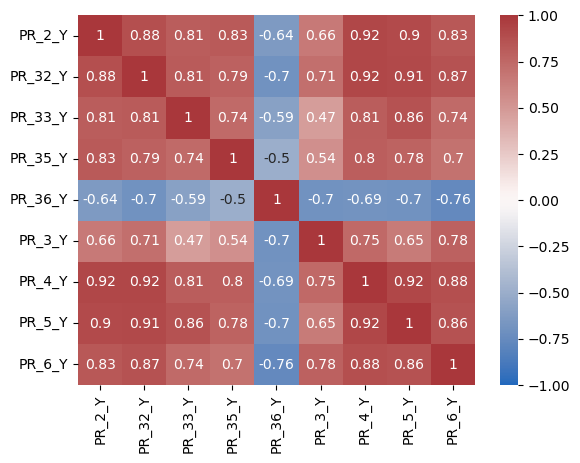

In [852]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

In [853]:
loadings = pd.DataFrame(fa.loadings_, columns = [f'factor_{i+1}' for i in range(n_factors)], index = [df.columns])
loadings

,factor_1,factor_2
PR_2_Y,0.844509,0.125801
PR_32_Y,0.694531,0.303363
PR_33_Y,0.988770,-0.131207
PR_35_Y,0.882269,-0.051002
PR_36_Y,-0.109645,-0.710160
PR_3_Y,-0.142999,1.003053
PR_4_Y,0.691588,0.327127
PR_5_Y,0.836670,0.155402
PR_6_Y,0.365375,0.631415


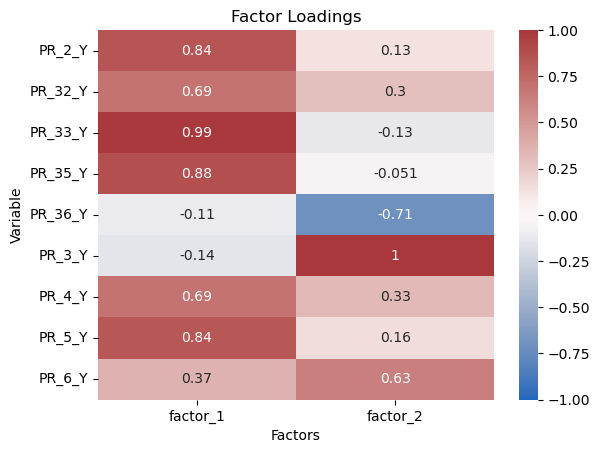

In [854]:
sns.heatmap(loadings, vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Factor Loadings');

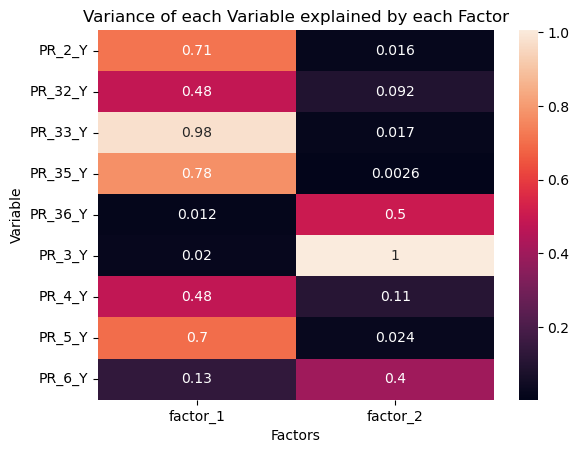

In [855]:
sns.heatmap(loadings.apply(lambda x: x**2), annot=True)
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Variance of each Variable explained by each Factor');

In [856]:
factor_var = pd.DataFrame(fa.get_factor_variance(), columns = [f'factor_{i+1}' for i in range(n_factors)], index=['variance', 
                                                                                                          'proportional_variance', 'cumulative_variance'])
factor_var

,factor_1,factor_2
variance,4.295916,2.167960
proportional_variance,0.477324,0.240884
cumulative_variance,0.477324,0.718209


In [857]:
data.isna().any()

PR_2_Y      False
PR_32_Y     False
PR_33_Y     False
PR_34_Y     False
PR_35_Y     False
PR_36_Y     False
PR_3_Y      False
PR_4_Y      False
PR_5_Y      False
PR_6_Y      False
PRSDEM01    False
PRSOTH01    False
PRSREP01    False
SENDEM01    False
SENREP01    False
dtype: bool

In [858]:
data = data.fillna(0)

In [859]:
cppi = pd.DataFrame(fa.transform(df), columns=[f'factor_{i+1}' for i in range(n_factors)], index = df.index)
cppi

,factor_1,factor_2
SVPREC_KEY,,
06001205200,1.428137,2.717494
06001547720,-0.459036,-0.115841
06001833300,0.419547,0.149696
06001333410,1.382733,1.715659
06001815140,-0.552022,-0.512993
...,...,...
060390005100,-1.071694,-1.308955
060390005169,-0.665757,-1.249128
060390005180,-0.217134,-0.484621


<Axes: >

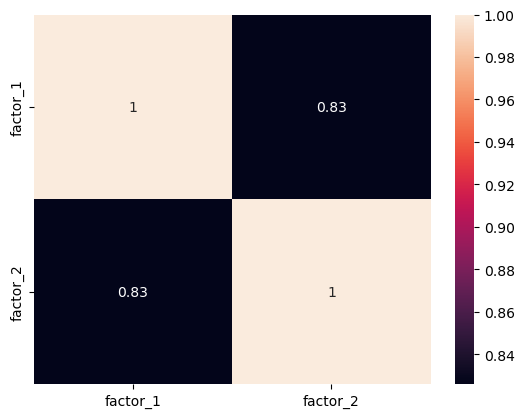

In [860]:
# Correlation between factors
sns.heatmap(cppi.corr(), annot=True)

In [861]:
cppi['factor_1'].mean(), cppi['factor_1'].std(), cppi['factor_1'].min(), cppi['factor_1'].max()

(1.1334679732962714e-16,
 0.9862820941207546,
 -4.211436746679232,
 3.4796407038547743)

In [862]:
cppi['factor_2'].mean(), cppi['factor_2'].std(), cppi['factor_2'].min(), cppi['factor_2'].max()

(-3.778226577654238e-17,
 0.9652335133583549,
 -4.0872349359031315,
 3.682828742867561)

In [863]:
# # conditional on only using factor 1
# cppi['cppi'] = (cppi['factor_1'] - cppi['factor_1'].min()) / (cppi['factor_1'].max() - cppi['factor_1'].min())
# cppi

In [864]:
cppi['cppi'] = cppi['factor_1'] + cppi['factor_2']
cppi['cppi_unstd'] = cppi['cppi']
cppi['cppi'] = (cppi['cppi'] - cppi['cppi'].min()) / (cppi['cppi'].max() - cppi['cppi'].min())
cppi

,factor_1,factor_2,cppi,cppi_unstd
SVPREC_KEY,,,,
06001205200,1.428137,2.717494,0.789926,4.145630
06001547720,-0.459036,-0.115841,0.454761,-0.574876
06001833300,0.419547,0.149696,0.535996,0.569243
06001333410,1.382733,1.715659,0.715570,3.098391
06001815140,-0.552022,-0.512993,0.419960,-1.065014
...,...,...,...,...
060390005100,-1.071694,-1.308955,0.326547,-2.380649
060390005169,-0.665757,-1.249128,0.359618,-1.914884
060390005180,-0.217134,-0.484621,0.445752,-0.701755


In [865]:
cppi['cppi'].min(), cppi['cppi'].max(), cppi['cppi'].mean(), cppi['cppi'].std()

(0.0, 1.0, 0.49557820341850284, 0.13239538187941202)

In [866]:
cppi['fips'] = cppi.index.map(lambda x: x[:5])
cppi.head()

,factor_1,factor_2,cppi,cppi_unstd,fips
SVPREC_KEY,,,,,
06001205200,1.428137,2.717494,0.789926,4.145630,06001
06001547720,-0.459036,-0.115841,0.454761,-0.574876,06001
06001833300,0.419547,0.149696,0.535996,0.569243,06001
06001333410,1.382733,1.715659,0.715570,3.098391,06001
06001815140,-0.552022,-0.512993,0.419960,-1.065014,06001


In [867]:
cppi_full = pd.merge(left=cppi.reset_index(), right=full_data, left_on='SVPREC_KEY', right_on='SRPREC_KEY', how='inner')
cppi_full.head()

,SVPREC_KEY,factor_1,factor_2,cppi,cppi_unstd,fips,SRPREC,COUNTY,FIPS_CODE,SRPREC_KEY,...,G24PR3_T,G24PR4_N,G24PR4_Y,G24PR4_Y_2,G24PR5_N,G24PR5_Y,G24PR5_T,G24PR6_N,G24PR6_Y,G24PR6_T
0,06001205200,1.428137,2.717494,0.789926,4.145630,06001,205200,001,06001,06001205200,...,3561,478,3049,3527,1139,2319,3458,721,2700,3421
1,06001547720,-0.459036,-0.115841,0.454761,-0.574876,06001,547720,001,06001,06001547720,...,3064,1349,1699,3048,2085,935,3020,1783,1157,2940
2,06001833300,0.419547,0.149696,0.535996,0.569243,06001,833300,001,06001,06001833300,...,2323,846,1476,2322,1258,1041,2299,1172,1069,2241
3,06001333410,1.382733,1.715659,0.715570,3.098391,06001,333410,001,06001,06001333410,...,2161,444,1704,2148,704,1427,2131,688,1407,2095
4,06001815140,-0.552022,-0.512993,0.419960,-1.065014,06001,815140,001,06001,06001815140,...,22,11,11,22,12,8,20,12,8,20


In [868]:
# EDA
cnty_cppi = cppi.groupby(['fips'])['factor_1'].agg(['median'])# .sort_values(['median'], ascending=False)
cnty_cppi

,median
fips,
06001,0.842663
06003,0.560755
06005,-1.136979
06007,-0.391543
06009,-1.191987
06011,-1.134468
06013,0.182499
06015,-0.590821
06017,-1.187717


In [869]:
cppi.to_csv('cppi/cppi_2024_only.csv')

In [870]:
cnty_f1 = {}
cnty_f2 = {}
cnty_cppi = {}

# cnty_f3 = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_f1 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_1'].map(lambda x: x + abs(cnty_df['factor_1'].min()))) - abs(cnty_df['factor_1'].min())
    weighted_avg_f2 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_2'].map(lambda x: x + abs(cnty_df['factor_2'].min()))) - abs(cnty_df['factor_2'].min())
    weighted_avg_cppi = np.sum(cnty_df['G24PTot'] * cnty_df['cppi'])
    cnty_f1.update({i: weighted_avg_f1})
    cnty_f2.update({i: weighted_avg_f2})
    cnty_cppi.update({i: weighted_avg_cppi})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_cppi

{'06001': 0.6365786316730719,
 '06003': 0.582831449295823,
 '06005': 0.34075811790028143,
 '06007': 0.45173321599373784,
 '06009': 0.3412079781758404,
 '06011': 0.3488131036182569,
 '06013': 0.5575823585823213,
 '06015': 0.38523550801005857,
 '06017': 0.3731002536855786,
 '06019': 0.4330545941398062,
 '06021': 0.3344513788084758,
 '06023': 0.5697159816208219,
 '06025': 0.49200057096162986,
 '06027': 0.44434707375223176,
 '06029': 0.40654706802193746,
 '06031': 0.3981747280131647,
 '06033': 0.4680029065983131,
 '06035': 0.2748581887269627,
 '06037': 0.5666175299101697,
 '06039': 0.38245346461435076,
 '06041': 0.6255916186580128,
 '06043': 0.3782144204015851,
 '06045': 0.5602148421735997,
 '06047': 0.46290374821017755,
 '06049': 0.3003474783254317,
 '06051': 0.5090611542057507,
 '06053': 0.5567064246190233,
 '06055': 0.532114947868885,
 '06057': 0.4787452329413979,
 '06059': 0.4541260032208188,
 '06061': 0.3844486586115685,
 '06063': 0.3781217119151139,
 '06065': 0.45917697405338564,
 '0

In [871]:
cnty_f1 = pd.DataFrame(cnty_f1, index=[0]).T.reset_index().rename({'index': 'fips', 0: 'avg_f1'}, axis=1)
cnty_f2 = pd.DataFrame(cnty_f2, index=[1]).T.reset_index().rename({'index': 'fips', 1: 'avg_f2'}, axis=1)
cnty_cppi = pd.DataFrame(cnty_cppi, index=[2]).T.reset_index().rename({'index': 'fips', 2: 'cppi'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f1, on='fips', how='inner')
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f2, on='fips', how='inner')
#cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f3, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2
0,06001,0.636579,0.888615,1.097252
1,06003,0.582831,0.401107,0.827779
2,06005,0.340758,-1.067095,-1.113410
3,06007,0.451733,-0.272285,-0.345233
4,06009,0.341208,-1.111815,-1.062354


In [872]:
def getCounties():
    "Function to return a dict of FIPS codes (keys) of U.S. counties (values)"
    d = {}
    r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
    reader = csv.reader(r.text.splitlines(), delimiter=',')    
    for line in reader:
        d[line[1] + line[2]] = line[3].replace(" County","")    
    return d

cnty_df = pd.DataFrame(getCounties(), index=[0]).T.reset_index().rename({'index': 'fips', 0:'cnty_name'}, axis=1)
cnty_df.head()

,fips,cnty_name
0,01001,Autauga
1,01003,Baldwin
2,01005,Barbour
3,01007,Bibb
4,01009,Blount


In [873]:
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_df, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name
0,06001,0.636579,0.888615,1.097252,Alameda
1,06003,0.582831,0.401107,0.827779,Alpine
2,06005,0.340758,-1.067095,-1.113410,Amador
3,06007,0.451733,-0.272285,-0.345233,Butte
4,06009,0.341208,-1.111815,-1.062354,Calaveras


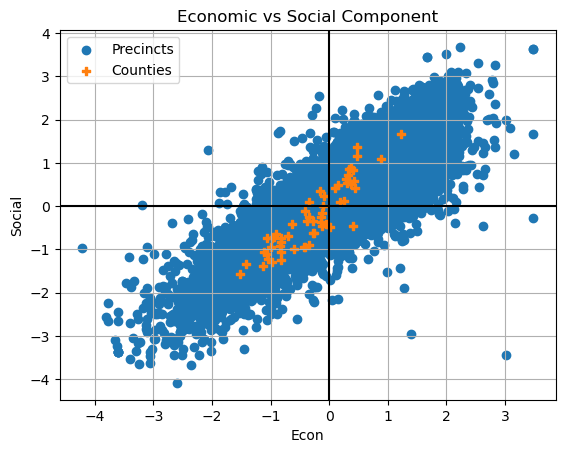

In [948]:
plt.scatter(cppi['factor_1'], cppi['factor_2'], label='Precincts')
plt.scatter(cnty_cppi['avg_f1'], cnty_cppi['avg_f2'], marker='P', label='Counties')
plt.xlabel('Econ')
plt.ylabel('Social')
plt.title('Economic vs Social Component')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.grid()
plt.legend();

In [876]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips',
       'SRPREC', 'COUNTY', 'FIPS_CODE', 'SRPREC_KEY', 'G24PDem',
       'G24PRep', 'G24POth', 'G24PTot', 'G24SDem', 'G24SRep', 'G24STot',
       'G24SSDem', 'G24SSRep', 'G24SSTot', 'G24HDem', 'G24HRep',
       'G24HTot', 'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem',
       'G24SLDLRep', 'G24SLDLTot', 'G24PR2_N', 'G24PR2_Y', 'G24PR2_T',
       'G24PR32_N', 'G24PR32_Y', 'G24PR32_T', 'G24PR33_N', 'G24PR33_Y',
       'G24PR33_T', 'G24PR34_N', 'G24PR34_Y', 'G24PR34_T', 'G24PR35_N',
       'G24PR35_Y', 'G24PR35_T', 'G24PR36_N', 'G24PR36_Y', 'G24PR36_T',
       'G24PR3_N', 'G24PR3_Y', 'G24PR3_T', 'G24PR4_N', 'G24PR4_Y',
       'G24PR4_Y_2', 'G24PR5_N', 'G24PR5_Y', 'G24PR5_T', 'G24PR6_N',
       'G24PR6_Y', 'G24PR6_T'], dtype=object)

In [877]:
cppi.columns.values

array(['factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips'], dtype=object)

Coefficient: [0.14977637], Intercept: 0.4349090861743882
r = [0.97020333]


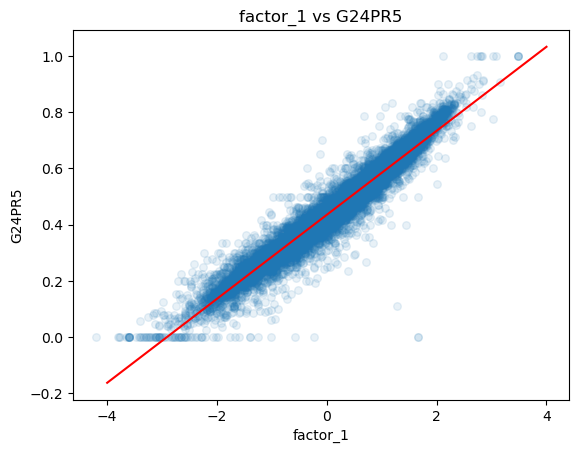

In [878]:
metric = 'factor_1'
race = 'G24PR5'

race_tot = cppi_full[f'{race}_Y'] + cppi_full[f'{race}_N']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, (cppi_full[f'{race}_Y'] / race_tot).values)
r = r_regression(cppi_full[[metric]], cppi_full[f'{race}_Y'] / race_tot)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], cppi_full[f'{race}_Y'] / race_tot, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel(race)
plt.title(f'{metric} vs {race}');

Coefficient: [0.08066721], Intercept: 0.5454138809981686
r = [0.88963385]


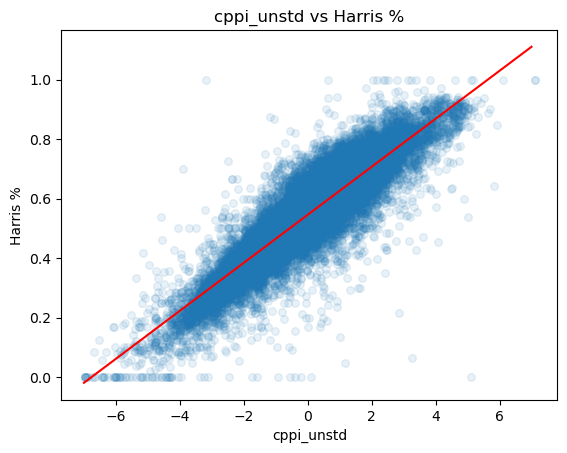

In [879]:
metric = 'cppi_unstd'
race = 'G24PDem'

race_pct = cppi_full[race] / cppi_full['G24PTot']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, race_pct.values)
r = r_regression(cppi_full[[metric]], race_pct)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-7, 7, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel('Harris %')
plt.title(f'{metric} vs Harris %');

Coefficient: [0.16377302], Intercept: 0.12157789512794275
r = [0.89230024]


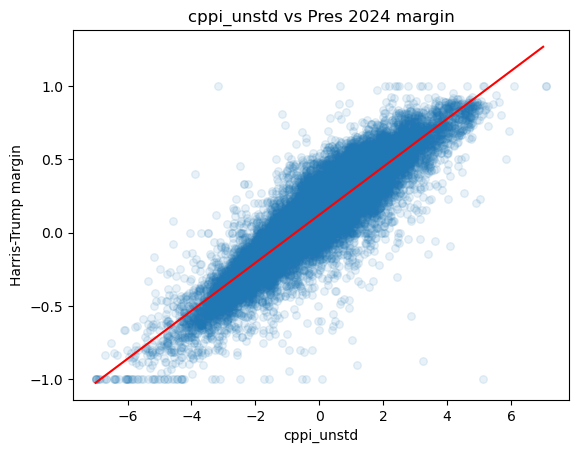

In [880]:
cppi_full['P24_margin'] = cppi_full['G24PDem'] - cppi_full['G24PRep']
metric = 'cppi_unstd'
race = 'P24_margin'

race_pct = cppi_full[race] / cppi_full['G24PTot']
cppi_full['P24_margin'] = race_pct

model = lm.LinearRegression().fit(cppi_full[[metric]].values, race_pct.values) ## CHANGE THIS! Dependent values are *bounded*
r = r_regression(cppi_full[[metric]], race_pct)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-7, 7, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel('Harris-Trump margin')
plt.title(f'{metric} vs Pres 2024 margin');

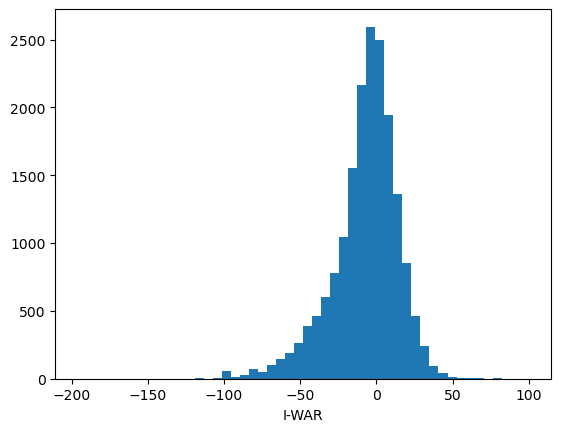

In [881]:
# We can create a sort of Harris ideological WAR (I-WAR) metric based on this
pred_margin = np.clip(model.predict(cppi_full[['cppi_unstd']]), 0, 1)
cppi_full['iwar'] = (cppi_full['P24_margin'] - pred_margin) * 100
plt.hist(cppi_full['iwar'], bins=50)
plt.xlabel('I-WAR');

In [882]:
cppi_full['iwar']

0        10.653270
1        29.244415
2         4.703164
3         3.630268
4        -9.090909
           ...    
18049   -32.926829
18050   -37.278107
18051   -24.989264
18052    -4.545455
18053   -57.142857
Name: iwar, Length: 18054, dtype: float64

In [883]:
cnty_iwar = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_iwar = np.sum(cnty_df['G24PTot'] * cnty_df['iwar'])
    cnty_iwar.update({i: weighted_avg_iwar})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_iwar

{'06001': 8.736087988576728,
 '06003': -0.3052964869878141,
 '06005': -28.109698205709975,
 '06007': -15.856725599388191,
 '06009': -28.31855210301253,
 '06011': -29.404238888027322,
 '06013': 10.809547304019326,
 '06015': -18.45154552878586,
 '06017': -15.466137693994604,
 '06019': -13.251665266907802,
 '06021': -36.61586367812402,
 '06023': -3.00903823512148,
 '06025': -15.943636611740056,
 '06027': -9.662438470771653,
 '06029': -28.541051048421814,
 '06031': -27.296081950810155,
 '06033': -9.182597603241078,
 '06035': -54.17030932677078,
 '06037': 2.899986232222415,
 '06039': -24.577289434282072,
 '06041': 21.753741598025925,
 '06043': -25.494559862155395,
 '06045': -1.4606365585872916,
 '06047': -16.75945489732539,
 '06049': -46.71562939775608,
 '06051': 0.9573275600906035,
 '06053': 2.522201498037257,
 '06055': 13.709247847835208,
 '06057': -2.2634072750360588,
 '06059': -6.48194648911583,
 '06061': -10.137120427864973,
 '06063': -19.723344753316976,
 '06065': -11.17452418317191,


In [884]:
cnty_iwar = pd.DataFrame(cnty_iwar, index=[3]).T.reset_index().rename({'index': 'fips', 3: 'iwar'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_iwar, on='fips')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name,iwar
0,06001,0.636579,0.888615,1.097252,Alameda,8.736088
1,06003,0.582831,0.401107,0.827779,Alpine,-0.305296
2,06005,0.340758,-1.067095,-1.113410,Amador,-28.109698
3,06007,0.451733,-0.272285,-0.345233,Butte,-15.856726
4,06009,0.341208,-1.111815,-1.062354,Calaveras,-28.318552


In [940]:
cnty_cppi.to_csv('cnty_cppi_2024_only.csv', index=False)